# Managing Andrews Data

In [1]:
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.transformations
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers import Flatten, Reshape, Conv3D, Conv3DTranspose
from keras.datasets import mnist
import numpy as np
from scipy.stats import norm
from scipy.spatial.transform import Rotation as R
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()

import matplotlib
import matplotlib.pyplot as plt

/home/twbadmin/notebook/tools/vae_tools/transformations.py:1924: UserWarning: No module named 'vae_tools._transformations'
  warnings.warn(str(err))


keras version: 2.1.6-tf
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True


In [2]:
# Store parameters
store_model = False # Train and store the model if "True" or loads existing models if "False"
store_model_overwrite = False # Overwrite model if it exists
store_model_prefix = "models/touchsensors_multisensory" # prefix for loading and storing

## Load and preprocess the data

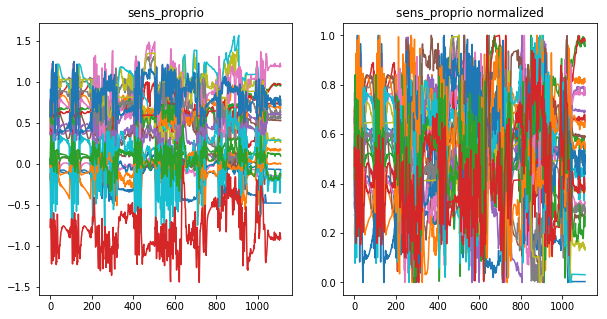

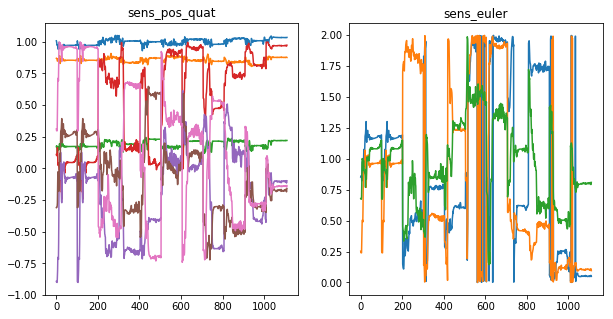

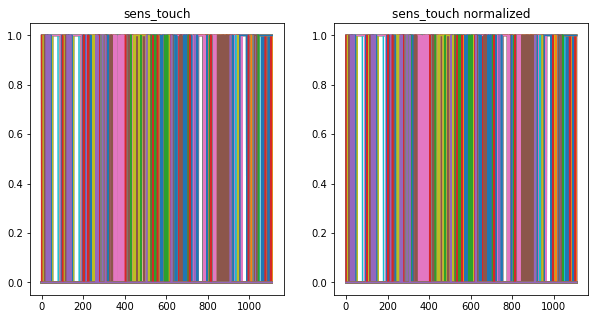

In [3]:
import urllib.request
import pickle
import os
import gzip

def download(url, location):    
    if not os.path.isfile(location):
        urllib.request.urlretrieve(url, location)

def norm_min_max(data, min = 0.0, max = 1.0, axis = None):
    ''' Scales the input data to the given minimum and maximum value
    
    data (np.array): The input data
    min     (float): Smallest value in data is scaled to this value
    max     (float): Biggest value in data is scaled to this value
    
    returns the normalized values
    '''
    data = data - np.min(data, axis = axis)
    data = data / np.max(data, axis = axis)
    data = (data * (max - min)) + min
    return data

def norm_min_max_native_range(data, native_min = -np.pi/2.0, native_max = np.pi/2.0, min = 0.0, max = 1.0):
    ''' Scales the input data to the given the native range of values to the minimum and maximum value
    
    data    (np.array): The input data
    native_min (float): Lower bound in the native data range
    native_max (float): Upper bound in the native data range
    min        (float): Smallest value in data is scaled to this value
    max        (float): Biggest value in data is scaled to this value
    
    returns the normalized values
    '''
    if (np.min(data) < native_min) or (np.max(data) > native_max):
        raise Exception("data outside of native range")
    data = (data - native_min) / native_max # scale to 0 ... 1 of native range
    data = (data * (max - min)) + min       # scale to desired range
    return data

filenames = ["multisensory_data_ep_162615.pgz", "multisensory_data_ep_162615.pgz", "multisensory_data_ep_162628.pgz", "multisensory_data_ep_162643.pgz", "multisensory_data_ep_162658.pgz", "multisensory_data_ep_162713.pgz", "multisensory_data_ep_162728.pgz", "multisensory_data_ep_162742.pgz", "multisensory_data_ep_162757.pgz", "multisensory_data_ep_162812.pgz", "multisensory_data_ep_162827.pgz"]
sens_proprio = None
sens_pos_quat = None
sens_touch = None
sens_voxel = None
for filename in filenames:
    url = "https://github.com/ndrwmlnk/baselines/blob/touchsensors_multisensory_data/HandManipulateBlockTouchSensors_multisensory_data/" + filename + "?raw=true"
    location = "/tmp/" + filename
    download(url, location)

    # Each file is a single episode (100 steps) and contains a dict:
    # senses = dict(
    # sens_proprio,  # 24 joint vaplues for - 24 degrees of freedom
    # sens_touch,  # 75 binary touch sensors: 0 - no touch, 1 - touch detected
    # sens_pos_quat,  # 7 value vectors: first 3 - XYZ of the cube, last 4 - quat values
    # sens_voxel  # 16x16x16 voxel space, cube shape is alwas in the center, cube size 8x8x8, check these links [1, 2] for visualization
    # )
    

    # Read '*.pgz' files:
    file = location
    with gzip.open(file, 'r') as f:
       data = pickle.load(f)
    #for k in data.keys():
    #   print(k, type(data[k]))
    
    if sens_proprio is None:
        sens_proprio = np.array(data["sens_proprio"])
    else:
        sens_proprio = np.append(sens_proprio, np.array(data["sens_proprio"]), axis=0)
    if sens_pos_quat is None:
        sens_pos_quat = np.array(data["sens_pos_quat"])
    else:
         sens_pos_quat = np.append(sens_pos_quat, np.array(data["sens_pos_quat"]), axis=0)
    if sens_touch is None:
        sens_touch = np.array(data["sens_touch"])
    else:
         sens_touch = np.append(sens_touch, np.array(data["sens_touch"]), axis=0)
    if sens_voxel is None:
        sens_voxel = np.array(data["sens_voxel"])
    else:
        sens_voxel = np.append(sens_voxel, np.array(data["sens_voxel"]), axis=0)


# sens_proprio
#sens_proprio = np.array(data["sens_proprio"])
f, axs = plt.subplots(1, 2, figsize=[10,5])
sens_proprio_norm = norm_min_max(sens_proprio, axis = 0)
axs[0].plot(sens_proprio)
axs[0].set_title("sens_proprio")
axs[1].plot(sens_proprio_norm)
axs[1].set_title("sens_proprio normalized")
plt.show()

# sens_pos_quat(float0..1 1x7)
#sens_pos_quat = np.array(data["sens_pos_quat"])
f, axs = plt.subplots(1, 2, figsize=[10,5])
sens_pos_euler = np.zeros([sens_pos_quat.shape[0], sens_pos_quat.shape[1]-1])
sens_pos_euler[:, 0:3] = sens_pos_quat[:, 0:3]
for pos_quat, pos_euler in zip(sens_pos_quat, sens_pos_euler):
    r = R.from_quat(pos_quat[3:])
    pos_euler[3:] = r.as_euler('zxy', degrees=False)
    # -pi .. pi, -pi .. pi, -pi/2 .. pi/2
    # https://scipy.github.io/devdocs/generated/scipy.spatial.transform.Rotation.as_euler.html#scipy.spatial.transform.Rotation.as_euler
# Plot the embedding
sens_euler = np.zeros(sens_pos_euler[:,3:].shape)
sens_euler[:,0] = norm_min_max_native_range(sens_pos_euler[:,3],native_min = -np.pi, native_max = np.pi, min = 0.0, max = 1.0)
sens_euler[:,2] = norm_min_max_native_range(sens_pos_euler[:,4],native_min = -np.pi/2., native_max = np.pi/2., min = 0.0, max = 1.0)
sens_euler[:,1] = norm_min_max_native_range(sens_pos_euler[:,5],native_min = -np.pi, native_max = np.pi, min = 0.0, max = 1.0)
axs[0].plot(sens_pos_quat)
axs[0].set_title("sens_pos_quat")
axs[1].plot(sens_euler)
axs[1].set_title("sens_euler")
plt.show()


# sens_voxel (float0..1 1x16x16x16 or 1x4096 if flatten)
#sens_voxel = np.array(data["sens_voxel"])
sens_voxel_norm = sens_voxel # already normalizes?
sens_voxel_flat_norm = sens_voxel_norm.reshape((len(sens_voxel_norm), np.prod(sens_voxel_norm.shape[1:])))
#print(sens_voxel_norm[0,0,0,:])
sens_voxel_norm_flatten = sens_voxel_norm.reshape((sens_voxel_norm.shape[0], -1))

# sens_touch (binary 1x75)
#sens_touch = np.array(data["sens_touch"])
f, axs = plt.subplots(1, 2, figsize=[10,5])
sens_touch_norm = sens_touch # already normalizes?
axs[0].plot(sens_touch)
axs[0].set_title("sens_touch")
axs[1].plot(sens_touch_norm)
axs[1].set_title("sens_touch normalized")
plt.show()

## Train touch data

Loaded model models/touchsensors_multisensory_sens_touch_enc_mean from disk
Loaded model models/touchsensors_multisensory_sens_touch_enc_logvar from disk
Loaded model models/touchsensors_multisensory_sens_touch_dec from disk


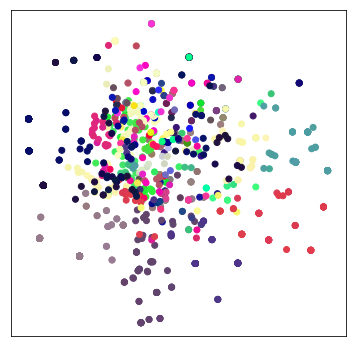

In [4]:
data = sens_touch_norm
model_name = "sens_touch"
if store_model:
    batch_size = 16
    original_dim = data.shape[1]
    intermediate_dim = 128
    epochs = 150
    z_dim = 2
    beta_norm = 0.01

    encoder_touch = [[
        Input(shape=(original_dim,)),                       # Input layer
        Dense(intermediate_dim, activation='relu'),         # First encoder layer
        Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
    ]]

    decoder_touch = [[
        Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
        Dense(intermediate_dim, activation='relu'),         # Second decoder layer
        Dense(original_dim, activation='sigmoid')           # Output layer
    ]]

    vae_obj = MmVae(z_dim, encoder_touch, decoder_touch, [original_dim], beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='sens_touch')

    vae = vae_obj.get_model()
    vae.compile(optimizer='rmsprop', loss=None)
    #vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
    # Store the losses, encodings, and decodings to tensorboard
    losses_cb = vae_tools.callbacks.Losses(data = data)
    # Train
    vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
    # Show the losses
    vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
    
    # Get the models
    encoder_input = [encoder_touch[0][0]]
    encoder_mean = vae_obj.get_encoder_mean(encoder_input)
    encoder_logvar = vae_obj.get_encoder_logvar(encoder_input)
    
    # Store model
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_dec", model = vae_obj.get_decoder(), overwrite = store_model_overwrite)
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_enc_mean", model = encoder_mean, overwrite = store_model_overwrite)
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_enc_logvar", model = encoder_logvar, overwrite = store_model_overwrite)
else:
    # Load the models
    encoder_mean =  MmVae.load_model(name = store_model_prefix + "_" + model_name + "_enc_mean")
    encoder_logvar =  MmVae.load_model(name = store_model_prefix + "_" + model_name + "_enc_logvar")
    decoder_mean = MmVae.load_model(name = store_model_prefix + "_" + model_name + "_dec")

# Plot the embedding
mean_encoded = encoder_mean.predict(data)
#var_encoded = np.sum(np.exp(encoder_logvar.predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
#vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
#plt.colorbar()
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.show()

Loaded model models/touchsensors_multisensory_sens_proprio_enc_mean from disk
Loaded model models/touchsensors_multisensory_sens_proprio_enc_logvar from disk
Loaded model models/touchsensors_multisensory_sens_proprio_dec from disk


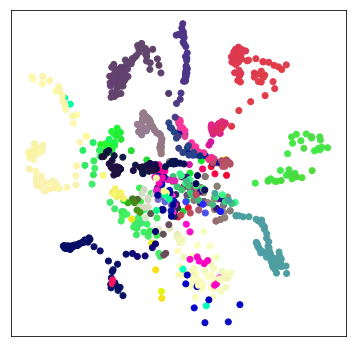

In [5]:
data = sens_proprio_norm
model_name = "sens_proprio"
if store_model:
    batch_size = 16
    original_dim = data.shape[1]
    intermediate_dim = 128
    epochs = 150
    z_dim = 2
    beta_norm = 0.01

    encoder_proprio = [[
        Input(shape=(original_dim,)),                       # Input layer
        Dense(intermediate_dim, activation='relu'),         # First encoder layer
        Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
    ]]

    decoder_proprio = [[
        Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
        Dense(intermediate_dim, activation='relu'),         # Second decoder layer
        Dense(original_dim, activation='sigmoid')           # Output layer
    ]]

    vae_obj = MmVae(z_dim, encoder_proprio, decoder_proprio, [original_dim], beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name=model_name)

    vae = vae_obj.get_model()
    vae.compile(optimizer='rmsprop', loss=None)
    #vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
    # Store the losses, encodings, and decodings to tensorboard
    losses_cb = vae_tools.callbacks.Losses(data = data)
    # Train
    vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
    # Show the losses
    vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
    # Get the models
    encoder_input = [encoder_proprio[0][0]]
    encoder_mean = vae_obj.get_encoder_mean(encoder_input)
    encoder_logvar = vae_obj.get_encoder_logvar(encoder_input)
    
    # Store model
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_dec", model = vae_obj.get_decoder(), overwrite = store_model_overwrite)
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_enc_mean", model = encoder_mean, overwrite = store_model_overwrite)
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_enc_logvar", model = encoder_logvar, overwrite = store_model_overwrite)
else:
    # Load the models
    encoder_mean =  MmVae.load_model(name = store_model_prefix + "_" + model_name + "_enc_mean")
    encoder_logvar =  MmVae.load_model(name = store_model_prefix + "_" + model_name + "_enc_logvar")
    decoder_mean = MmVae.load_model(name = store_model_prefix + "_" + model_name + "_dec")
# Plot the embedding
mean_encoded = encoder_mean.predict(data)
#var_encoded = np.sum(np.exp(encoder_logvar.predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
#vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
#plt.colorbar()
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.show()

Loaded model models/touchsensors_multisensory_sens_voxel_enc_mean from disk
Loaded model models/touchsensors_multisensory_sens_voxel_enc_logvar from disk


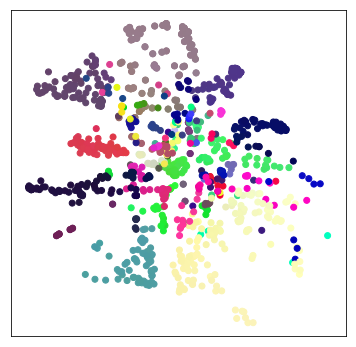

In [6]:
use_conv = True
model_name = "sens_voxel"
if use_conv:
    data = sens_voxel_norm[:, :, :, :, None] # For conv VAE
else:
    data = sens_voxel_flat_norm              # For dense VAE
if store_model:
    rows, cols, depth, chns = sens_voxel_norm[:, :, :, :, None].shape[1:]
    original_dim = (rows, cols, depth, chns)
    batch_size = 16
    original_dim_prod = np.prod(data.shape[1:])
    intermediate_dim = 64
    epochs = 150
    z_dim = 2
    beta_norm = 0.01

    filters = 64
    if use_conv:
        encoder_voxel = [[
            Input(shape=original_dim),
            Conv3D(filters = 1, kernel_size = (2,2,2), strides=(2,2,2), padding='same',activation='relu'),
            Conv3D(filters = filters, kernel_size = (2,2,2), strides=(2,2,2), padding='same',activation='relu'),
            Conv3D(filters = filters, kernel_size = (3,3,3), strides=(1,1,1), padding='same',activation='relu'),
            Conv3D(filters = filters, kernel_size = (3,3,3), strides=(1,1,1), padding='same',activation='relu'),
            Flatten(),
            Dense(intermediate_dim, activation='relu'),
            Dense(int(intermediate_dim/2), activation='relu')
        ]]

        output_shape = (8, 8, 8, filters)
        decoder_voxel = [[
            Dense(int(intermediate_dim/2), activation='relu'),
            Dense(intermediate_dim, activation='relu'),
            Dense(filters * 8 * 8 * 8, activation='relu'),
            Reshape(output_shape),
            Conv3DTranspose(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same', activation='relu'),
            Conv3DTranspose(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same', activation='relu'),
            Conv3DTranspose(filters, kernel_size=(3,3,3), strides=(2,2,2), padding='valid', activation='relu'),
            Conv3D(filters = 1, kernel_size = (2,2,2), strides=(1,1,1), padding='valid',activation='sigmoid')
        ]]
    else:
        encoder_voxel = [[
            Input(shape=(original_dim_prod,)),
            Dense(intermediate_dim, activation='relu'),
            Dense(int(intermediate_dim/2), activation='relu')
        ]]

        decoder_voxel = [[
            Dense(int(intermediate_dim/2), activation='relu'),
            Dense(intermediate_dim, activation='relu'),
            Dense(original_dim_prod, activation='sigmoid')
        ]]

    vae_obj = MmVae(z_dim, encoder_voxel, decoder_voxel, [original_dim_prod], beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name=model_name)

    vae = vae_obj.get_model()
    vae.compile(optimizer='rmsprop', loss=None)
    #vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
    # Store the losses, encodings, and decodings to tensorboard
    losses_cb = vae_tools.callbacks.Losses(data = data)
    # Train
    vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
    # Show the losses
    vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
    plt.show()
   # Get the models
    encoder_input = [encoder_voxel[0][0]]
    encoder_mean = vae_obj.get_encoder_mean(encoder_input)
    encoder_logvar = vae_obj.get_encoder_logvar(encoder_input)
    
    # Store model
    #vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_dec", model = vae_obj.get_decoder(), overwrite = store_model_overwrite)
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_enc_mean", model = encoder_mean, overwrite = store_model_overwrite)
    vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_enc_logvar", model = encoder_logvar, overwrite = store_model_overwrite)
else:
    # Load the models
    encoder_mean =  MmVae.load_model(name = store_model_prefix + "_" + model_name + "_enc_mean")
    encoder_logvar =  MmVae.load_model(name = store_model_prefix + "_" + model_name + "_enc_logvar")
    #decoder_mean = MmVae.load_model(name = store_model_prefix + "_" + model_name + "_dec")
# Plot the embedding
mean_encoded = encoder_mean.predict(data)
#var_encoded = np.sum(np.exp(encoder_logvar.predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
#vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
#plt.colorbar()
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.show()

## Bimodal VAE (Proprio & Voxel)

Loaded model models/touchsensors_multisensory_sens_proprio_voxel_enc_mean_ProprioVoxel10 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_enc_mean_ProprioVoxel01 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_enc_mean_ProprioVoxel11 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_enc_logvar_ProprioVoxel10 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_enc_logvar_ProprioVoxel01 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_enc_logvar_ProprioVoxel11 from disk


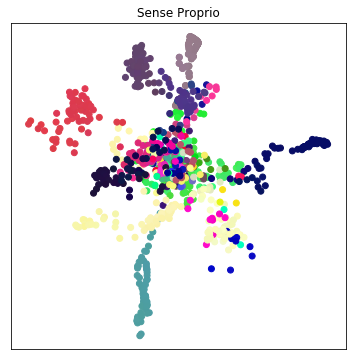

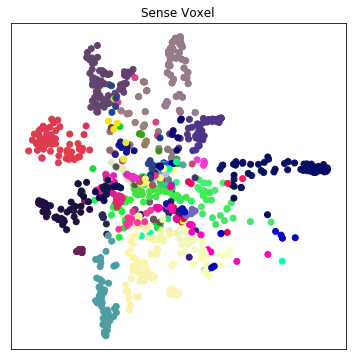

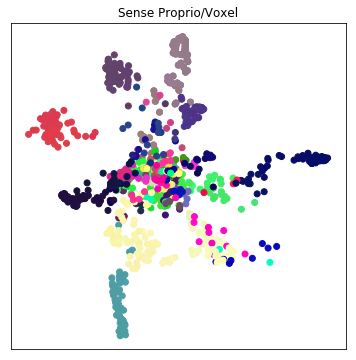

In [7]:
# Multi modal training of proprio and voxel
data = [sens_proprio_norm, sens_voxel_norm[:, :, :, :, None]]
model_name = "sens_proprio_voxel"
if store_model:

    batch_size = 16
    epochs = 150
    z_dim = 2
    beta_norm = 0.01

    # Pin the weights
    for layer in encoder_proprio[0]:
        layer.trainable = False
    for layer in decoder_proprio[0][1:]:
        layer.trainable = False
    for layer in encoder_voxel[0]:
        layer.trainable = False
    for layer in decoder_voxel[0][1:]:
        layer.trainable = False

    encoder_pv = [encoder_proprio[0], encoder_voxel[0]]
    decoder_pv = [decoder_proprio[0], decoder_voxel[0]]

    vae_obj = MmVae(z_dim, encoder_pv, decoder_pv, [sens_proprio_norm.shape[1], sens_voxel_norm.shape[1]],
                    beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name=model_name)

    vae = vae_obj.get_model()
    vae.compile(optimizer='rmsprop', loss=None)
    #vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
    # Store the losses, encodings, and decodings to tensorboard
    losses_cb = vae_tools.callbacks.Losses(data = data)
    # Train
    vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
    # Show the losses
    vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
   # Get the models
    encoder_input = [encoder_pv[0][0], encoder_pv[1][0]]
    encoder_mean = [vae_obj.get_encoder_mean([encoder_input[0]]),
                                 vae_obj.get_encoder_mean([encoder_input[1]]),
                                 vae_obj.get_encoder_mean(encoder_input)]
    encoder_logvar = [vae_obj.get_encoder_logvar([encoder_input[0]]),
                                   vae_obj.get_encoder_logvar([encoder_input[1]]),
                                   vae_obj.get_encoder_logvar(encoder_input)]
    
    # Store model
    #vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_dec", model = vae_obj.get_decoder(), overwrite = store_model_overwrite)
    vae_obj.store_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_mean_ProprioVoxel",
                                 model_inputs = encoder_input,
                                 get_model_callback = vae_obj.get_encoder_mean, overwrite = store_model_overwrite)
    vae_obj.store_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_logvar_ProprioVoxel",
                                 model_inputs = encoder_input,
                                 get_model_callback = vae_obj.get_encoder_logvar, overwrite = store_model_overwrite)
else:
    # Load the models
    #decoder_mean = MmVae.load_model(name = store_model_prefix + "_" + model_name + "_dec")
    encoder_mean, _ =  MmVae.load_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_mean_ProprioVoxel",
                                             num_elements = 2)
    encoder_logvar, _ =  MmVae.load_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_logvar_ProprioVoxel",
                                               num_elements = 2)

mean_encoded = encoder_mean[0].predict(data[0])
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.title("Sense Proprio")

mean_encoded = encoder_mean[1].predict(data[1])
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.title("Sense Voxel")

# Plot the embedding proprio and voxel
mean_encoded = encoder_mean[2].predict(data)
#var_encoded = np.sum(np.exp(encoder_logvar[2].predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
#vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
#plt.colorbar()
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.title("Sense Proprio/Voxel")
plt.show()

### Bimodal VAE (Proprio, Voxel, Touch)

Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_mean_ProprioVoxelTouch100 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_mean_ProprioVoxelTouch010 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_mean_ProprioVoxelTouch110 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_mean_ProprioVoxelTouch001 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_mean_ProprioVoxelTouch101 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_mean_ProprioVoxelTouch011 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_mean_ProprioVoxelTouch111 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_logvar_ProprioVoxelTouch100 from disk
Loaded model models/touchsensors_multisensory_sens_proprio_voxel_touch_enc_logvar_ProprioVoxelTouch010 from di

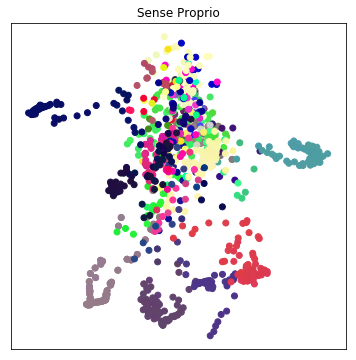

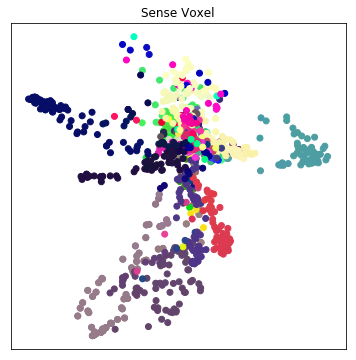

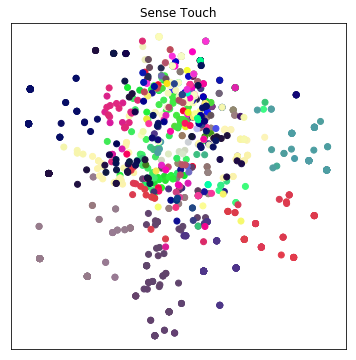

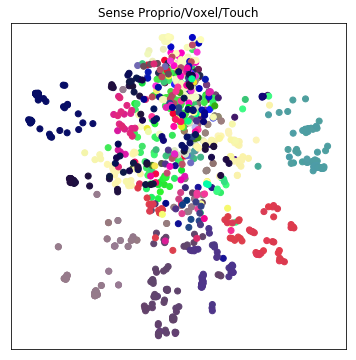

In [8]:
# Multi modal training of proprio and voxel
data = [sens_proprio_norm, sens_voxel_norm[:, :, :, :, None], sens_touch_norm]
model_name = "sens_proprio_voxel_touch"
if store_model:

    batch_size = 16
    epochs = 150
    z_dim = 2
    beta_norm = 0.01

    # Pin the weights
    for layer in encoder_proprio[0]:
        layer.trainable = False
    for layer in decoder_proprio[0][1:]:
        layer.trainable = False
    for layer in encoder_voxel[0]:
        layer.trainable = False
    for layer in decoder_voxel[0][1:]:
        layer.trainable = False
    for layer in encoder_touch[0]:
        layer.trainable = False
    for layer in decoder_touch[0][1:]:
        layer.trainable = False

    encoder_pvt = [encoder_proprio[0], encoder_voxel[0], encoder_touch[0]]
    decoder_pvt = [decoder_proprio[0], decoder_voxel[0], decoder_touch[0]]

    vae_obj = MmVae(z_dim, encoder_pvt, decoder_pvt, [sens_proprio_norm.shape[1], sens_voxel_norm.shape[1], sens_touch_norm.shape[1]],
                    beta_norm, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name=model_name)

    vae = vae_obj.get_model()
    vae.compile(optimizer='rmsprop', loss=None)
    #vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
    # Store the losses, encodings, and decodings to tensorboard
    losses_cb = vae_tools.callbacks.Losses(data = data)
    # Train
    vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
    # Show the losses
    vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
   # Get the models
    encoder_input = [encoder_pvt[0][0], encoder_pvt[1][0], encoder_pvt[2][0]]

    # Store model
    #vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_dec", model = vae_obj.get_decoder(), overwrite = store_model_overwrite)
    vae_obj.store_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_mean_ProprioVoxelTouch",
                                 model_inputs = encoder_input,
                                 get_model_callback = vae_obj.get_encoder_mean, overwrite = store_model_overwrite)
    vae_obj.store_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_logvar_ProprioVoxelTouch",
                                 model_inputs = encoder_input,
                                 get_model_callback = vae_obj.get_encoder_logvar, overwrite = store_model_overwrite)
# Load the models
#decoder_mean = MmVae.load_model(name = store_model_prefix + "_" + model_name + "_dec")
encoder_mean, _ =  MmVae.load_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_mean_ProprioVoxelTouch",
                                         num_elements = 3)
encoder_logvar, _ =  MmVae.load_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_logvar_ProprioVoxelTouch",
                                           num_elements = 3)

mean_encoded = encoder_mean[0].predict(data[0])
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.title("Sense Proprio")

mean_encoded = encoder_mean[1].predict(data[1])
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.title("Sense Voxel")

mean_encoded = encoder_mean[3].predict(data[2])
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.title("Sense Touch")

# Plot the embedding proprio and voxel
mean_encoded = encoder_mean[-1].predict(data)
#var_encoded = np.sum(np.exp(encoder_logvar[2].predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
#vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
#plt.colorbar()
vae_tools.viz.plot_embedding(mean_encoded, sens_euler, colormap='hsv', figsize=(6, 6))
plt.axis("equal")
plt.title("Sense Proprio/Voxel/Touch")
plt.show()